In [108]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import geopy.distance

In [109]:
def ns(path):
    return path.format(
        gpx='{http://www.topografix.com/GPX/1/1}',
        tpx="{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}"
    )

In [110]:
def dirn(slope, flat):
    if slope > flat: return 1
    if slope < (flat * -1): return 0
    return 0.5

In [141]:
#tree = ET.parse("longmire.gpx")
#tree = ET.parse("cowlitz.gpx")
#tree = ET.parse("Evening_Run.gpx")
tree = ET.parse("Obliteride.gpx")
root = tree.getroot()

In [142]:
data = [
    (
        float(trkpt.get('lat')), 
        float(trkpt.get('lon')), 
        float(trkpt.find(ns('{gpx}ele')).text),
        pd.to_datetime(trkpt.find(ns('{gpx}time')).text)
        
    )
    for trkpt in root.findall(ns('.//{gpx}trkpt'))]

df = pd.DataFrame(data, columns=['lat', 'lon', 'ele', 'time'])
df.head()

lat         lon  ele                      time
0  47.657114 -122.299465  0.0 2019-08-10 13:02:52+00:00
1  47.657114 -122.299465  0.0 2019-08-10 13:02:56+00:00
2  47.657114 -122.299465 -0.2 2019-08-10 13:02:57+00:00
3  47.657098 -122.299479 -0.2 2019-08-10 13:03:02+00:00
4  47.656930 -122.299563 -0.2 2019-08-10 13:03:09+00:00

In [143]:
for i in range(1, len(df)):
    a = df.iloc[i-1]
    b = df.iloc[i]
    df.loc[i, 'd_dist'] = geopy.distance.distance((a['lat'], a['lon']), (b['lat'], b['lon']), ellipsoid = 'WGS-84').km * 1000
    
df['dist'] = df['d_dist'].cumsum()
df['d_time'] = (df['time'] - df['time'].shift()).dt.seconds
df['time_s'] = df['d_time'].cumsum()
df.head()

lat         lon  ele                      time     d_dist       dist  \
0  47.657114 -122.299465  0.0 2019-08-10 13:02:52+00:00        NaN        NaN   
1  47.657114 -122.299465  0.0 2019-08-10 13:02:56+00:00   0.000000   0.000000   
2  47.657114 -122.299465 -0.2 2019-08-10 13:02:57+00:00   0.000000   0.000000   
3  47.657098 -122.299479 -0.2 2019-08-10 13:03:02+00:00   2.066545   2.066545   
4  47.656930 -122.299563 -0.2 2019-08-10 13:03:09+00:00  19.715862  21.782407   

   d_time  time_s  
0     NaN     NaN  
1     4.0     4.0  
2     1.0     5.0  
3     5.0    10.0  
4     7.0    17.0

In [144]:
d_x = 100.0
xs = []
x = 0
max = df['dist'].max()
while x < max:
    xs.append(x)
    x += d_x
    
dfnew = pd.DataFrame()
dfnew['dist'] = xs
dfnew['ele'] = np.interp(xs, df['dist'], df['ele'])
dfnew['time_s'] = np.interp(xs, df['dist'], df['time_s'])
dfraw = df
df = dfnew
df.head()

dist       ele     time_s
0    0.0 -0.200000   5.000000
1  100.0 -0.494525  31.681557
2  200.0 -2.200000  51.638165
3  300.0 -2.076502  70.617492
4  400.0  2.000000  88.886123

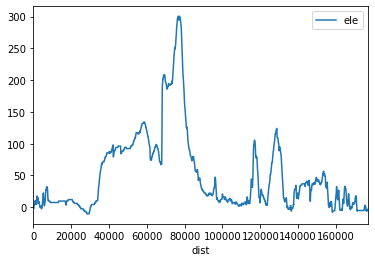

In [145]:
df.plot(x='dist', y='ele')

In [146]:
df.plot(x='time_s', y='ele')

In [147]:
df['d_ele'] = df['ele'] - df['ele'].shift() 
df['d_dist'] = df['dist'] - df['dist'].shift()
df['slope'] = df['d_ele'] / d_x
df['smooth_slope'] = df['slope'].ewm(com=20).mean()
df['dirn'] = df['slope'].apply(lambda slope: dirn(slope, 0.01))

df['n_ele'] = (df['ele']-df['ele'].min()) / (df['ele'].max()-df['ele'].min())

dfnew.head(10)

dist       ele      time_s     d_ele  d_dist     slope  smooth_slope  \
0    0.0 -0.200000    5.000000       NaN     NaN       NaN           NaN   
1  100.0 -0.494525   31.681557 -0.294525   100.0 -0.002945     -0.002945   
2  200.0 -2.200000   51.638165 -1.705475   100.0 -0.017055     -0.010172   
3  300.0 -2.076502   70.617492  0.123498   100.0  0.001235     -0.006183   
4  400.0  2.000000   88.886123  4.076502   100.0  0.040765      0.006427   
5  500.0  2.375031  104.875157  0.375031   100.0  0.003750      0.005838   
6  600.0  4.000000  119.101641  1.624969   100.0  0.016250      0.007792   
7  700.0  4.000000  133.310725  0.000000   100.0  0.000000      0.006509   
8  800.0  6.200000  148.331819  2.200000   100.0  0.022000      0.008792   
9  900.0  8.200000  164.559239  2.000000   100.0  0.020000      0.010294   

   dirn     n_ele  
0   0.5  0.033419  
1   0.5  0.032473  
2   0.0  0.026992  
3   0.5  0.027389  
4   1.0  0.040488  
5   0.5  0.041694  
6   1.0  0.046915  
7   0.5  0.046915  
8   1.0  0.053985  
9   1.0  0.060411

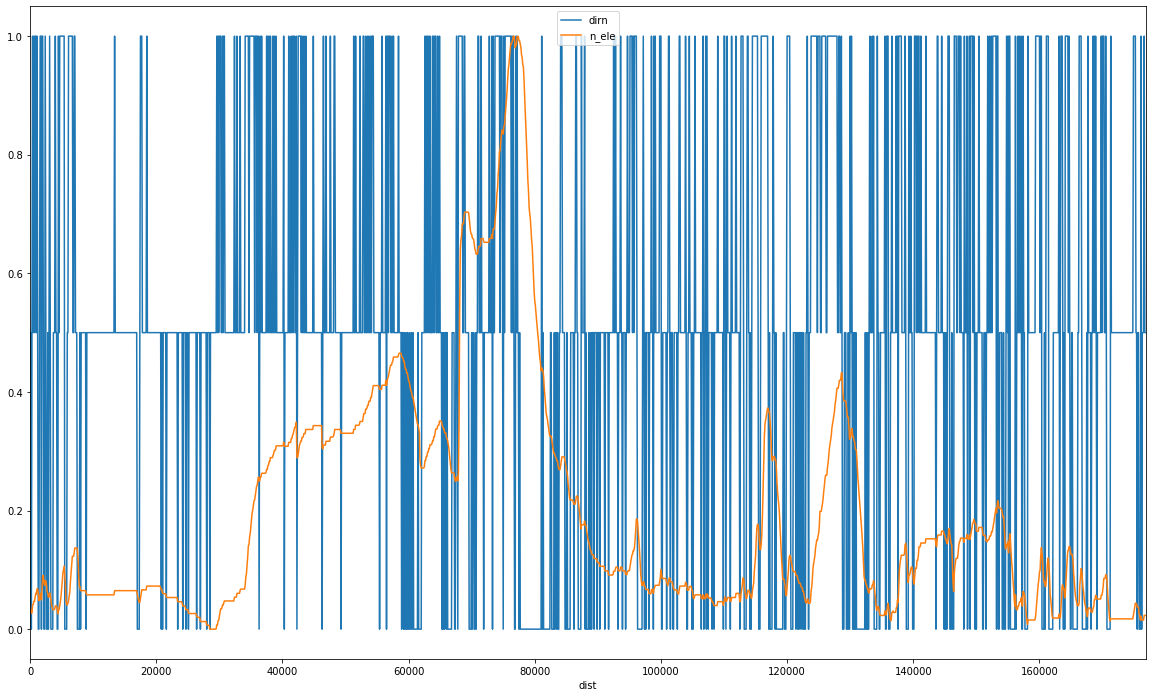

In [148]:
df.plot(x='dist', y=['dirn', 'n_ele'], figsize=(20, 12))

In [149]:
dirn2color = {
    0   : 'r',
    0.5 : 'b',
    1   : 'g'
}

In [166]:
segments = []
row = df.iloc[1]
seg = { 'start' : 0,'end': 1, 'dirn' : row['dirn'], 'dist': row['d_dist'] }

i = 2
while i < df.shape[0]:
    row = df.iloc[i]    
    if row['dirn'] == seg['dirn']:
        seg['dist'] += row['d_dist']
        seg['end'] = i
    else:
        segments.append(seg)
        seg = { 'start': i-1, 'end': i, 'dirn': row['dirn'], 'dist': row['d_dist'] }
    i += 1
segments.append(seg)
    
segments = pd.DataFrame(segments)

In [167]:
segments.head(20)

start  end  dirn   dist
0       0    1   0.5  100.0
1       1    2   0.0  100.0
2       2    3   0.5  100.0
3       3    4   1.0  100.0
4       4    5   0.5  100.0
5       5    6   1.0  100.0
6       6    7   0.5  100.0
7       7    9   1.0  200.0
8       9   10   0.5  100.0
9      10   11   1.0  100.0
10     11   12   0.5  100.0
11     12   14   0.0  200.0
12     14   15   0.5  100.0
13     15   17   1.0  200.0
14     17   18   0.0  100.0
15     18   20   1.0  200.0
16     20   21   0.5  100.0
17     21   23   0.0  200.0
18     23   24   1.0  100.0
19     24   25   0.5  100.0

In [168]:
def merge_row(segments, idx):
    if idx == 0:
        segments.loc[idx+1,"start"] = segments.loc[idx,"start"]
        segments.loc[idx+1,"dist"] += segments.loc[idx,"dist"]
        segments = segments.drop(idx)     
    elif idx == segments.shape[0]-1:
        segments.loc[idx-1,"end"] = segments.loc[idx,"end"]
        segments.loc[idx-1,"dist"] += segments.loc[idx,"dist"]
        segments = segments.drop(idx)     
    elif segments.loc[idx-1, "dirn"] == segments.loc[idx+1, "dirn"]:
        segments.loc[idx-1,"end"] = segments.loc[idx+1, "end"]
        segments.loc[idx-1,"dist"] += segments.loc[idx, "dist"] + segments.loc[idx+1, "dist"]
        segments = segments.drop([idx, idx+1])    
    else:
        ratio = segments.loc[idx-1, "dist"] / segments.loc[idx+1, "dist"]
        if ratio > 0.75:
            segments.loc[idx-1,"end"] = segments.loc[idx, "end"]
            segments.loc[idx-1,"dist"] += segments.loc[idx, "dist"]
        elif ratio < 0.25:
            segments.loc[idx+1,"start"] = segments.loc[idx, "start"]
            segments.loc[idx+1,"dist"] += segments.loc[idx, "dist"]
        else:
            mid_point = (segments.loc[idx, "start"] + segments.loc[idx, "end"]) // 2
            mid_dist = segments.loc[idx, "dist"] / 2.0
            segments.loc[idx-1,"end"] = mid_point
            segments.loc[idx-1,"dist"] += mid_dist
            segments.loc[idx+1,"end"] = mid_point
            segments.loc[idx+1,"dist"] += mid_dist
        segments = segments.drop(idx)     
    
    return segments.reset_index(drop=True)    

In [169]:
def compact(segments):
    i = 0
    while i < segments.shape[0]-1: 
        if segments.loc[i, "dirn"] == segments.loc[i+1, "dirn"]:
            segments.loc[i, "end"] = segments.loc[i+1, "end"]
            segments.loc[i, "dist"] += segments.loc[i+1, "dist"]
            segments = segments.drop(i+1)
            segments = segments.reset_index(drop=True)
        else:
            i += 1
    return segments

In [170]:
min_segment = 5000

while True:
    min_idx = segments.idxmin('index')['dist']
    if segments.loc[min_idx, "dist"] > min_segment:
        break
        
    segments = merge_row(segments, min_idx)
    segments = compact(segments)

In [171]:
segments.head(20)

start   end  dirn     dist
0      0    39   1.0   7400.0
1     74   661   0.5  58700.0
2    661   832   0.0  17100.0
3    832  1221   0.5  38900.0
4   1237  1221   1.0   7200.0
5   1293  1347   0.0   5400.0
6   1347  1538   0.5  19100.0
7   1540  1677   0.0  13900.0
8   1677  1769   0.5   9200.0

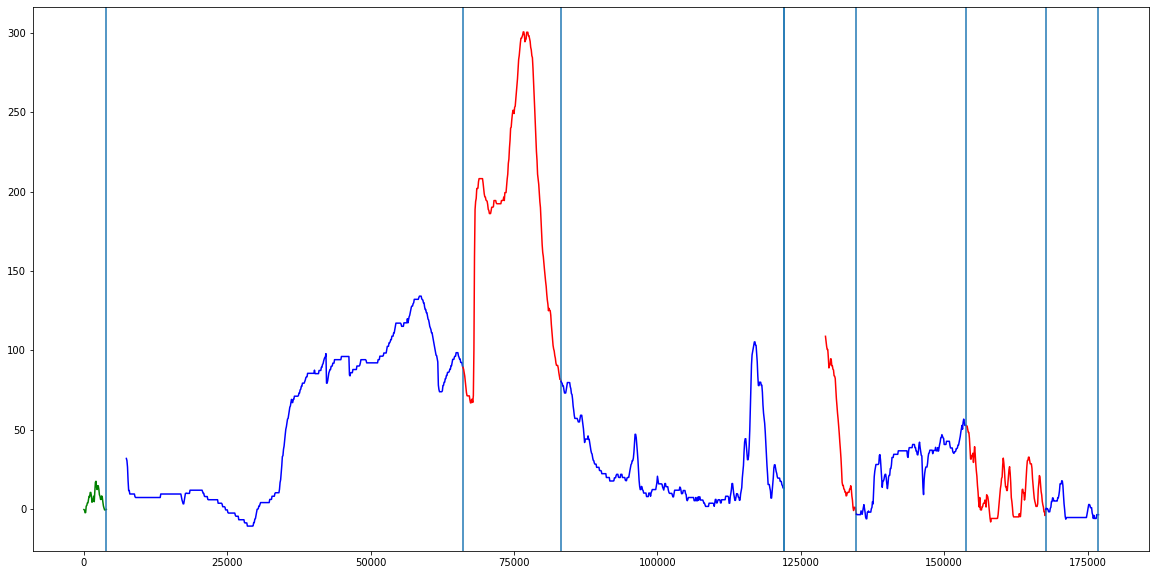

In [172]:
plt.figure(figsize=(20,10))

for i, seg in segments.iterrows():
    plt.plot('dist', 'ele', data = df.iloc[int(seg['start']) : int(seg['end'])+1], color = dirn2color[seg['dirn']])
    plt.axvline(x = df.loc[int(seg['end']), "dist"])
    
plt.show()